## effect size sharing for multi-gene qtls

say we have a qtl that impacts multiple genes. How does the fractional effect of that qtl on each gene vary? w.r.t for instance distance from qtl to tss? maybe tie in ABC connections here? Maybe build a model that predicts how qtl impact on each gene will be split based on gene baseline expression, distance, ect

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
import scipy as sp
from scipy.stats import linregress


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

import upsetplot as up
#from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = list(tissue_df['Tissue'])

# select just 1 tissue id to do for now 
my_tissue_id = 'Lung' # because only one cell type
#tissue_ids = [tissue_id]

### load in data
* effect sizes for qtls
* overlap dfs
* gencode for tss starts

take the subset of varaints in pcqtl determined credible sets, and calculate the varience-explained on a per gene basis for each gene in the cluster and for the cluster-pc overall

variance for each egene-cluster-credibleset(pc and cs num)

In [3]:
def add_variance(nominal_df):
    nominal_df['variance'] = nominal_df['slope'].apply(np.square) * 100

def get_var_explained(row, nominal_df):
    var_list = row['variant_id']
    pip_list = row['pip']
    # make sure all varaints are in the nominal df
    try:
        nominal_df['variance']
    except KeyError:
        add_variance(nominal_df)
    sub_nominal = nominal_df.loc[var_list]
    sub_nominal = sub_nominal[sub_nominal['cluster_id'] == row['cluster_id']]
    # add pips to the df    
    sub_nominal = sub_nominal.merge(pd.Series(pip_list, index=pd.Series(var_list, name='variant_id'), name='pip'), on='variant_id')
    sub_nominal['variance_weighted'] = sub_nominal['variance'] * sub_nominal['pip']
    # sum over each phenotype to get the total weighted varience
    return sub_nominal.groupby('phenotype_id').agg({'variance_weighted':'sum'}).reset_index()


def get_slope_pip_weighted(row, nominal_df):
    var_list = row['variant_id']
    pip_list = row['pip']
    # make sure all varaints are in the nominal df
    sub_nominal = nominal_df.loc[var_list]
    sub_nominal = sub_nominal[sub_nominal['cluster_id'] == row['cluster_id']]
    # add pips to the df    
    sub_nominal = sub_nominal.merge(pd.Series(pip_list, index=pd.Series(var_list, name='variant_id'), name='pip'), on='variant_id')
    sub_nominal['slope_weighted'] = sub_nominal['slope'] * sub_nominal['pip']
    # sum over each phenotype to get the total weighted varience
    return sub_nominal.groupby('phenotype_id').agg({'slope_weighted':'sum'}).reset_index()


def add_pip_weighted_slope(cs_grouped_pc_susie, vid_pc_nominal, vid_e_nominal):
    for idx, row in tqdm(cs_grouped_pc_susie.iterrows(), total=len(cs_grouped_pc_susie)):
        pc_slope_weighted = get_slope_pip_weighted(row, vid_pc_nominal)
        try:
            cs_grouped_pc_susie.loc[idx, 'matching_pc_slope'] = pc_slope_weighted[pc_slope_weighted['phenotype_id'].str.split('_pc').str[-1] == str(row['pc_num'])].iloc[0]['slope_weighted']
        except IndexError as e:
            print(pc_slope_weighted)
            print(pc_slope_weighted['phenotype_id'])
            print(row['pc_num'])
            raise e
        e_var_weighted = get_slope_pip_weighted(row, vid_e_nominal)
        cs_grouped_pc_susie.loc[idx, 'e_slope'] = str(e_var_weighted['slope_weighted'].to_list())
        cs_grouped_pc_susie.loc[idx, 'e_slope_phenotypes'] = str(e_var_weighted['phenotype_id'].to_list())

    cs_grouped_pc_susie['e_slope_max'] = [max(ast.literal_eval(e_slope), key=abs) for e_slope in cs_grouped_pc_susie['e_slope']]
    cs_grouped_pc_susie['e_slope_average'] = [np.mean(ast.literal_eval(e_slope)) for e_slope in cs_grouped_pc_susie['e_slope']]
    return cs_grouped_pc_susie


def add_sign_flipped_slopes(config, my_tissue_id, annot_cs_grouped_pc_susie):
    pc_df = load_pc(config, my_tissue_id)
    expression_df = load_cluster_expression(config, my_tissue_id)  
    sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]

    # add the slopes to the pc df
    for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
        expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
        gene_slopes = []
        gene_variances = []
        for egene_id in row['cluster_id'].split('_'):
            expression_values = expression_cluster[expression_cluster['egene_id']==egene_id][sample_ids].values.astype('float')            # pull the right data
            pc_values = row[sample_ids].astype('float')
            # get the r squared value
            slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
            gene_slopes.append(slope)
            gene_variances.append((r_value**2)*100)
        pc_df.loc[idx, 'variance_list'] = str(gene_variances)
        pc_df.loc[idx, 'slope_list'] = str(gene_slopes)

    pc_df['variance_list_explode'] = pc_df['variance_list'].apply(ast.literal_eval)
    pc_df['slope_list_explode'] = pc_df['slope_list'].apply(ast.literal_eval)
    pc_df['transcript_list_explode'] = pc_df['cluster_id'].str.split('_')

    # flip the signs for pc-e pairs with negative slopes 
    for idx, row in tqdm(annot_cs_grouped_pc_susie.iterrows(), total=len(annot_cs_grouped_pc_susie)):
        matching_pc_df_row = pc_df[pc_df['gene_id'] == row['pc_id']].explode(['slope_list_explode', 'transcript_list_explode', 'variance_list_explode'])
        pc_egene_slopes=[]
        pc_egene_vars = []
        for e_phenotype in ast.literal_eval(row['e_slope_phenotypes']):
            egene_id = e_phenotype.split('_e_')[-1]
            pc_egene_slopes.append(matching_pc_df_row[matching_pc_df_row['transcript_list_explode'] == egene_id]['slope_list_explode'].iloc[0])
            pc_egene_vars.append(matching_pc_df_row[matching_pc_df_row['transcript_list_explode'] == egene_id]['variance_list_explode'].iloc[0])

        annot_cs_grouped_pc_susie.loc[idx, 'pc_egene_slopes'] = str(pc_egene_slopes)
        annot_cs_grouped_pc_susie.loc[idx, 'pc_egene_vars'] = str(pc_egene_vars)

        sign_flipped_slopes = np.asarray(ast.literal_eval(row['e_slope'])) * np.asarray([1 if p>0 else -1 for p in pc_egene_slopes])
        annot_cs_grouped_pc_susie.loc[idx, 'e_slope_sign_flipped'] = str(sign_flipped_slopes.tolist())
        annot_cs_grouped_pc_susie.loc[idx, 'e_slope_slope_weighted'] = str((np.asarray(ast.literal_eval(row['e_slope'])) * np.asarray(pc_egene_slopes)).tolist())
        annot_cs_grouped_pc_susie.loc[idx, 'e_slope_var_weighted'] = str((np.asarray(sign_flipped_slopes) * np.asarray(pc_egene_vars)).tolist())



In [4]:
def get_annotated_pc_susie(config, my_tissue_id, plot=False):
    print(my_tissue_id)

    e_nominal = load_e_nominal_all_chr(config, my_tissue_id)
    pc_nominal = load_pc_nominal_all_chr(config, my_tissue_id)
    pc_susie = load_pc_susie(config, my_tissue_id)
    pc_susie['chr'] = pc_susie['variant_id'].str.split('chr').str[1].str.split('_').str[0]
    print("\tloaded data")

    vid_pc_nominal = pc_nominal.set_index('variant_id')
    vid_pc_nominal = vid_pc_nominal.loc[pc_susie['variant_id']]
    if plot:
        sns.histplot(vid_pc_nominal, x='slope')
        plt.show()

    vid_e_nominal = e_nominal.set_index('variant_id')
    vid_e_nominal = vid_e_nominal.loc[pc_susie['variant_id']]


    # this is on the level of the credible set, so group the susie output by credible set
    cs_grouped_pc_susie = pc_susie.groupby('cs_id').agg({'pip':list, 
                                'variant_id': list,
                                'cs_num':'first',
                                'pc_num':'first',
                                'lead_variant_id':'first',
                                'num_vars':'first',
                                'cluster_id':'first', 
                                'chr':'first'})
    print("\tannotating credible sets with slopes")
    cs_grouped_pc_susie = add_pip_weighted_slope(cs_grouped_pc_susie, vid_pc_nominal, vid_e_nominal)

    if plot:
        ax = sns.histplot(cs_grouped_pc_susie, x='e_slope_max')
        plt.xlabel('pip weighted slope')
        plt.show()
        ax = sns.scatterplot(cs_grouped_pc_susie, x='e_slope_max', y='matching_pc_slope')
        plt.show()

    # add in credible set overlap information
    print("\tannotating credible sets with overlap df")
    overlap = load_overlap(config, my_tissue_id)
    overlap['cs_id'] = overlap['cs_full_id'].str.split('cs').str.join('')
    annot_cs_grouped_pc_susie = pd.merge(cs_grouped_pc_susie, overlap[['num_e_samelead', 'num_pc_samelead', 'num_pc_overlap', 'num_e_overlap', 'cs_id', 'e_overlap']], on='cs_id', how='left')

    # add in cluster info 
    print("\tannotating credible sets with cluster df")
    cluster_df = load_clusters_annotated(config, my_tissue_id)
    annot_cs_grouped_pc_susie = pd.merge(annot_cs_grouped_pc_susie, cluster_df, on='cluster_id', how='left')

    annot_cs_grouped_pc_susie['abs_cor'] = np.where(annot_cs_grouped_pc_susie['Mean_neg_cor'].isna(), annot_cs_grouped_pc_susie['Mean_pos_cor'], - annot_cs_grouped_pc_susie['Mean_neg_cor'])
    annot_cs_grouped_pc_susie['abs_cor'] = np.where(annot_cs_grouped_pc_susie['abs_cor'] < annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['abs_cor'])

    annot_cs_grouped_pc_susie['max_pos_neg_cor'] = np.where(annot_cs_grouped_pc_susie['Mean_neg_cor'].isna(), annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_neg_cor'])
    annot_cs_grouped_pc_susie['max_pos_neg_cor'] = np.where(abs(annot_cs_grouped_pc_susie['max_pos_neg_cor']) < annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['max_pos_neg_cor'])
    annot_cs_grouped_pc_susie['pc_id'] = annot_cs_grouped_pc_susie['cs_id'].str.replace(r'(_\d+)$', '', regex=True)

    # add in sign flipped slopes 
    add_sign_flipped_slopes(config, my_tissue_id, annot_cs_grouped_pc_susie)

    return annot_cs_grouped_pc_susie

In [5]:
test_annot_cs_grouped_pc_susie = get_annotated_pc_susie(config, 'Muscle_Skeletal')

Muscle_Skeletal
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [01:32<00:00, 17.38it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [00:14<00:00, 113.71it/s]


<AxesSubplot: xlabel='e_slope_explode', ylabel='matching_pc_slope'>

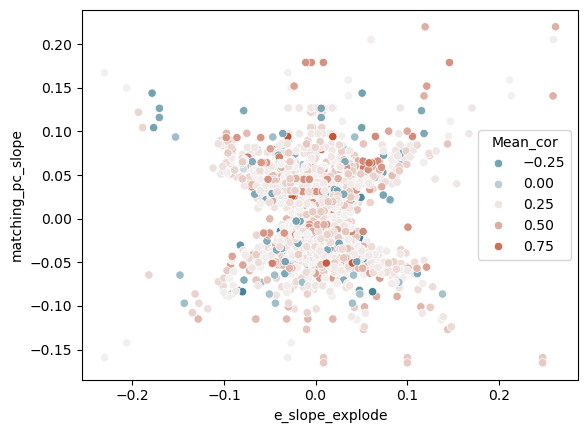

In [6]:
test_annot_cs_grouped_pc_susie['e_slope_explode'] = test_annot_cs_grouped_pc_susie['e_slope'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_explode'), x='e_slope_explode', y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='e_slope_sign_flipped_explode', ylabel='matching_pc_slope'>

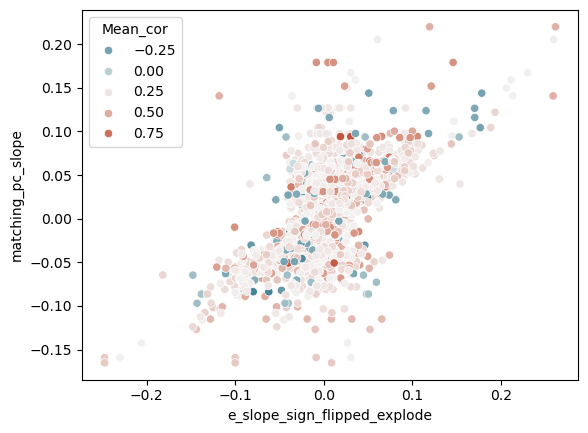

In [7]:
test_annot_cs_grouped_pc_susie['e_slope_sign_flipped_explode'] = test_annot_cs_grouped_pc_susie['e_slope_sign_flipped'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_sign_flipped_explode'), x='e_slope_sign_flipped_explode', y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='e_slope_slope_weighted_explode', ylabel='matching_pc_slope'>

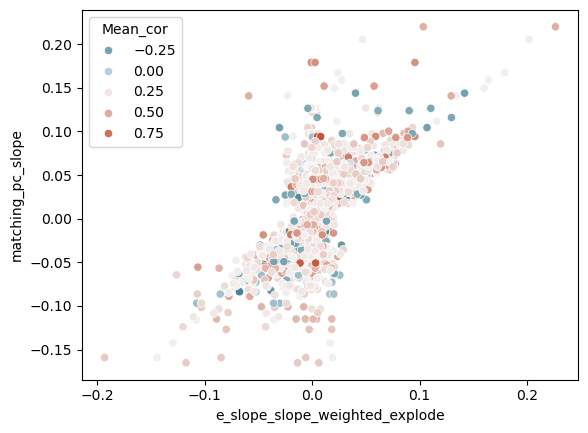

In [8]:
test_annot_cs_grouped_pc_susie['e_slope_slope_weighted_explode'] = test_annot_cs_grouped_pc_susie['e_slope_slope_weighted'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_slope_weighted_explode'), x='e_slope_slope_weighted_explode', 
                y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='e_slope_var_weighted_explode', ylabel='matching_pc_slope'>

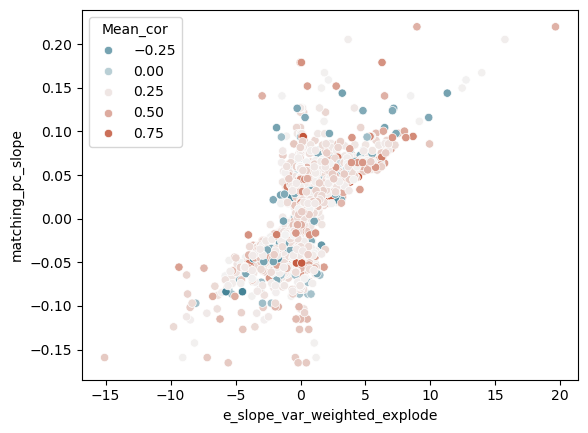

In [9]:
test_annot_cs_grouped_pc_susie['e_slope_var_weighted_explode'] = test_annot_cs_grouped_pc_susie['e_slope_var_weighted'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_var_weighted_explode'), x='e_slope_var_weighted_explode', y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

## combine across tissues

In [10]:
# get it for all the tissues
annot_cs_grouped_pc_susie = load_across_tissues(config, get_annotated_pc_susie)

Adipose_Subcutaneous
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1578/1578 [01:26<00:00, 18.33it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1578/1578 [00:13<00:00, 112.88it/s]


Adipose_Visceral_Omentum
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1045/1045 [00:44<00:00, 23.33it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1045/1045 [00:09<00:00, 115.01it/s]


Artery_Tibial
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1652/1652 [01:28<00:00, 18.70it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1652/1652 [00:14<00:00, 117.15it/s]


Cells_Cultured_fibroblasts
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:05<00:00, 25.46it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:14<00:00, 113.92it/s]


Esophagus_Mucosa
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1421/1421 [01:18<00:00, 18.16it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1421/1421 [00:12<00:00, 116.10it/s]


Esophagus_Muscularis
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1182/1182 [00:45<00:00, 26.14it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1182/1182 [00:09<00:00, 119.63it/s]


Lung
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [01:02<00:00, 19.79it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:11<00:00, 104.92it/s]


Muscle_Skeletal
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [01:29<00:00, 18.04it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [00:14<00:00, 115.01it/s]


Nerve_Tibial
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1787/1787 [01:25<00:00, 20.94it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1787/1787 [00:14<00:00, 120.83it/s]


Skin_Not_Sun_Exposed_Suprapubic
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1364/1364 [01:20<00:00, 16.99it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1364/1364 [00:11<00:00, 117.77it/s]


Skin_Sun_Exposed_Lower_leg
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1804/1804 [01:51<00:00, 16.16it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1804/1804 [00:14<00:00, 122.60it/s]


Thyroid
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2168/2168 [02:17<00:00, 15.76it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2168/2168 [00:17<00:00, 123.11it/s]


Whole_Blood
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [01:28<00:00, 19.01it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:14<00:00, 119.00it/s]


In [13]:
import os
os.makedirs(f'{prefix}/temp/')
annot_cs_grouped_pc_susie.to_csv(f'{prefix}/temp/effect_size_annotated_overlap_all_tissues.txt', sep='\t')

In [5]:
annot_cs_grouped_pc_susie = pd.read_csv(f'{prefix}/temp/effect_size_annotated_overlap_all_tissues.txt', sep='\t', index_col=0)

In [6]:
# effect size differences here?
annot_cs_grouped_pc_susie['exclusive_label'] = np.where((annot_cs_grouped_pc_susie['num_e_samelead'] > 0), np.where((annot_cs_grouped_pc_susie['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
annot_cs_grouped_pc_susie['pc_egene_vars'] =  annot_cs_grouped_pc_susie['pc_egene_vars'].apply(ast.literal_eval)

In [7]:
annot_cs_grouped_pc_susie['effect_size'] = annot_cs_grouped_pc_susie['e_slope_max']**2

In [8]:
annot_cs_grouped_pc_susie['max_egene_var'] = annot_cs_grouped_pc_susie['pc_egene_vars'].apply(max)

Text(0.5, 0, 'maximum egene % variance explained')

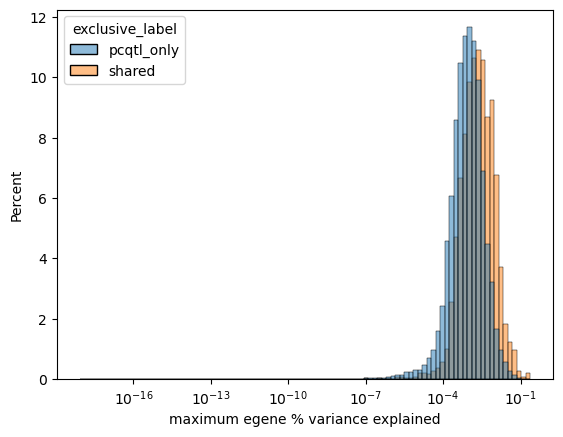

In [9]:
ax = sns.histplot(annot_cs_grouped_pc_susie, x='effect_size', hue='exclusive_label', log_scale=True, common_norm=False, bins=100, stat='percent')
ax.set_xlabel('maximum egene % variance explained')

look at just those that impact multiple genes. are the genes more correlated?

<AxesSubplot: xlabel='max_pos_neg_cor', ylabel='Percent'>

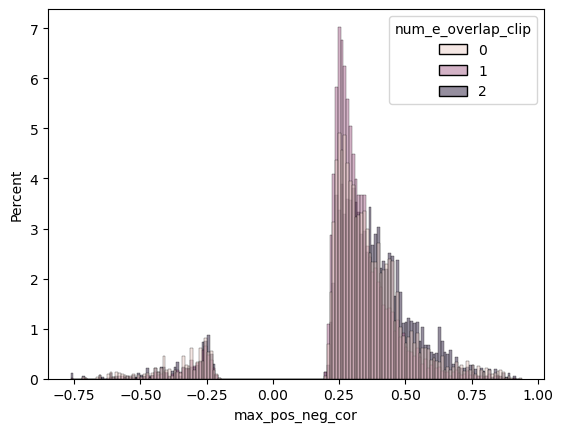

In [10]:
annot_cs_grouped_pc_susie['num_e_overlap_clip'] = annot_cs_grouped_pc_susie['num_e_overlap'].clip(0,2) 
sns.histplot(annot_cs_grouped_pc_susie, x='max_pos_neg_cor', hue='num_e_overlap_clip', common_norm=False, stat='percent')

In [39]:
annot_cs_grouped_pc_susie

,cs_id,pip,variant_id,cs_num,pc_num,lead_variant_id,num_vars,cluster_id,chr,matching_pc_slope,...,pc_egene_slopes,pc_egene_vars,e_slope_sign_flipped,e_slope_slope_weighted,e_slope_var_weighted,tissue_id,exclusive_label,effect_size,max_egene_var,num_e_overlap_clip
0,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,"[0.2690568, 0.20032704, 0.1347186, 0.2936548, ...","['chr1_196853900_T_G_b38', 'chr1_196856834_A_G...",1,1,chr1_196868521_T_C_b38,6,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,0.027087,...,"[-0.7409920992319063, -0.7250957714408917, -0....","[54.90693844207257, 52.57639227791427, 50.1213...","[0.008206389740088442, 0.030390197968480494, 0...","[0.006080869960623313, 0.022035804040196783, 0...","[0.450587736290692, 1.5978069697943038, 0.4938...",Adipose_Subcutaneous,pcqtl_only,0.000924,54.906938,1
1,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,"[0.021360993, 0.021360993, 0.017427087, 0.0213...","['chr1_196382020_A_C_b38', 'chr1_196388616_A_G...",2,1,chr1_196447806_GAC_G_b38,30,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,-0.024098,...,"[-0.7409920992319063, -0.7250957714408917, -0....","[54.90693844207257, 52.57639227791427, 50.1213...","[-0.025184353993623624, -0.016320965500357987,...","[-0.018661407333534615, -0.011834263070142252,...","[-1.382795774431257, -0.858097484501127, -0.95...",Adipose_Subcutaneous,shared,0.000634,54.906938,2
2,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,[0.98504657],['chr1_196740093_A_T_b38'],1,2,chr1_196740093_A_T_b38,1,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,0.022094,...,"[0.467802467586444, -0.4842826481835277, 0.529...","[21.88391860969454, 23.452970366185593, 28.073...","[-0.0071030522034998145, 0.032127369483383406,...","[-0.003322825348192542, 0.015558727572583569, ...","[-0.1554426163018014, 0.7534822444372864, -0.2...",Adipose_Subcutaneous,shared,0.001032,28.140731,1
3,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,"[0.0302248, 0.010810018, 0.010810018, 0.009014...","['chr1_196382020_A_C_b38', 'chr1_196382636_A_T...",2,2,chr1_196402302_T_C_b38,38,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,0.002323,...,"[0.467802467586444, -0.4842826481835277, 0.529...","[21.88391860969454, 23.452970366185593, 28.073...","[0.0060826177540127205, -0.0048195147676156555...","[0.0028454635947122646, -0.0023340073746205285...","[0.13311151186269737, -0.11303193702428381, 0....",Adipose_Subcutaneous,shared,0.000037,28.140731,2
4,ENSG00000001460.17_ENSG00000001461.16_pc1_1,"[0.013464093, 0.0626955, 0.0626955, 0.0626955,...","['chr1_24402426_ATCT_A_b38', 'chr1_24405169_G_...",1,1,chr1_24415329_A_G_b38,12,ENSG00000001460.17_ENSG00000001461.16,1,-0.040837,...,"[0.8137592721605411, 0.8137591567245858]","[66.22040794940062, 66.2203952962003]","[-0.040074593443185015, -0.026389189318771454]","[-0.03261107199245583, -0.021474444446688903]","[-2.653755926214087, -1.7475025482353121]",Adipose_Subcutaneous,shared,0.001606,66.220408,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20199,ENSG00000276070.4_ENSG00000276085.1_pc1_2,[0.9984328],['chr17_36182122_G_T_b38'],2,1,chr17_36182122_G_T_b38,1,ENSG00000276070.4_ENSG00000276085.1,17,-0.043498,...,"[-0.9373685404437381, -0.937368440872092]","[87.865976090035, 87.8659716422175]","[-0.02990945272374153, -0.05163762853219509]","[-0.028036180045124585, -0.04840348334755597]","[-2.6280232578903058, -4.5371904042812155]",Whole_Blood,shared,0.002666,87.865976,1
20200,ENSG00000276070.4_ENSG00000276085.1_pc1_3,[0.99428946],['chr17_36467153_T_C_b38'],3,1,chr17_36467153_T_C_b38,1,ENSG00000276070.4_ENSG00000276085.1,17,0.060505,...,"[-0.9373685404437381, -0.937368440872092]","[87.865976090035, 87.8659716422175]","[0.0643565006165041, 0.04907368622873537]","[0.06032575905095897, 0.046000124748075924]","[5.6547467444080715, 4.311907122553142]",Whole_Blood,shared,0.004142,87.865976,1
20201,ENSG00000276070.4_ENSG00000276085.1_pc1_4,"[0.22711182, 0.3819728, 0.3819728]","['chr17_36143679_A_G_

## multigene comparisions
take those that are called as eqtls for multiple genes.
look at how the effect size for 1 gene changes the effect size for the other

In [11]:
multiegene_cs_grouped = annot_cs_grouped_pc_susie[annot_cs_grouped_pc_susie['num_e_overlap']>1].reset_index(drop=True)
len(multiegene_cs_grouped)

3702

In [12]:
# look at the distribution of each slope vs the average slope. if an eqtl is shared, does it tend to impact all the genes roughly the same?

for idx, row in multiegene_cs_grouped.iterrows():
    egenes = [e_phenotype.split('_e_')[-1] for e_phenotype in ast.literal_eval(row['e_slope_phenotypes'])]
    sig_egenes = [e_phenotype.split('_e_')[1] for e_phenotype in ast.literal_eval(row['e_overlap'])]
    sig_egene_filter = pd.Series(egenes).isin(sig_egenes)
    sig_e_slope = np.asarray(ast.literal_eval(row['e_slope']))[sig_egene_filter]

    average_sig_slope = np.average(sig_e_slope)

    multiegene_cs_grouped.loc[idx, 'sig_slope'] = str(list(sig_e_slope))
    multiegene_cs_grouped.loc[idx, 'abs_sig_slope'] = str(list(abs(sig_e_slope)))

    multiegene_cs_grouped.loc[idx, 'average_sig_slope'] = average_sig_slope
    multiegene_cs_grouped.loc[idx, 'frac_average_slope'] = str(list(sig_e_slope/average_sig_slope))
    multiegene_cs_grouped.loc[idx, 'diff_average_slope'] = str(list(sig_e_slope - average_sig_slope))

    
multiegene_cs_grouped['sig_slope'] = multiegene_cs_grouped['sig_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['abs_sig_slope'] = multiegene_cs_grouped['abs_sig_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['frac_average_slope'] = multiegene_cs_grouped['frac_average_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['diff_average_slope'] = multiegene_cs_grouped['diff_average_slope'].apply(ast.literal_eval)

<AxesSubplot: xlabel='sig_slope', ylabel='Percent'>

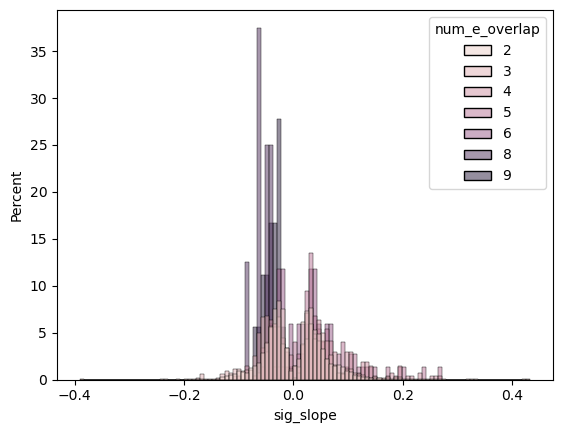

In [13]:
# plot the distribution of the fraction of average, colored by how many sig egenes the var has
sns.histplot(data = multiegene_cs_grouped.explode('sig_slope'), x='sig_slope', hue='num_e_overlap', common_norm=False, stat='percent')

In [18]:
gid_gencode, full_gencode = load_gencode()
multiegene_cs_grouped['lead_var_position'] = var_pos(multiegene_cs_grouped, column='lead_variant_id')

for idx, row in multiegene_cs_grouped.iterrows():
    sig_egenes = [e_var_phenotype.split('_e_')[1] for e_var_phenotype in ast.literal_eval(row['e_overlap'])]
    sig_egenes = pd.Series(sig_egenes).unique()
    sig_tss_starts = gid_gencode.loc[sig_egenes]['tss_start']
    multiegene_cs_grouped.loc[idx, 'num_sig_egenes'] = len(sig_egenes) # might be different from num_e_overlap if one egene has multiple cs
    multiegene_cs_grouped.loc[idx, 'sig_tss_starts']  = str(list(sig_tss_starts))
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance']  = str(list(row['lead_var_position'] - sig_tss_starts))
    abs_distances = abs(sig_tss_starts - row['lead_var_position'])
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance_abs']  = str(list(abs_distances))
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance_diff']  = str(list(abs_distances - np.average(abs_distances)))
    multiegene_cs_grouped.loc[idx, 'sig_egenes'] = str(list(sig_egenes))
    


multiegene_cs_grouped['sig_tss_var_distance'] = multiegene_cs_grouped['sig_tss_var_distance'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_tss_var_distance_abs'] = multiegene_cs_grouped['sig_tss_var_distance_abs'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_tss_var_distance_diff'] = multiegene_cs_grouped['sig_tss_var_distance_diff'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_egenes'] = multiegene_cs_grouped['sig_egenes'].apply(ast.literal_eval)

# drop those with multiple cs for the same egene 
multiegene_cs_grouped = multiegene_cs_grouped[multiegene_cs_grouped['num_sig_egenes'] > 1]
len(multiegene_cs_grouped)

3694

## pairs

In [19]:
# to start, look only at pairs as this is a bit easier to understand
pairegene_cs_grouped = multiegene_cs_grouped[multiegene_cs_grouped['num_sig_egenes'] == 2]
pairegene_cs_grouped = pairegene_cs_grouped[pairegene_cs_grouped['N_genes']==2]

<AxesSubplot: xlabel='frac_slope', ylabel='Count'>

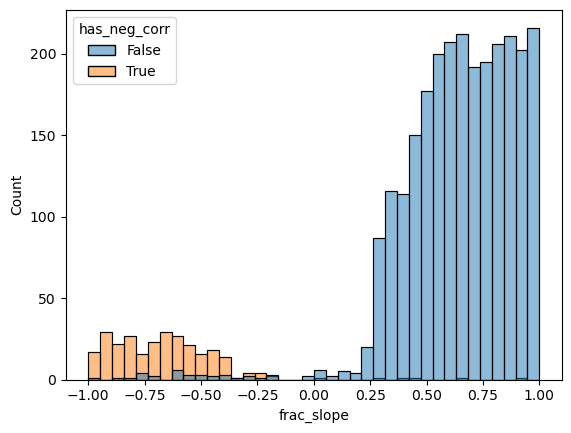

In [32]:
# dependent variable is fraction of slope
pairegene_cs_grouped['frac_slope'] = np.where(abs(pairegene_cs_grouped['sig_slope'].str[0]) > abs(pairegene_cs_grouped['sig_slope'].str[1]), pairegene_cs_grouped['sig_slope'].str[1]/pairegene_cs_grouped['sig_slope'].str[0], pairegene_cs_grouped['sig_slope'].str[0]/pairegene_cs_grouped['sig_slope'].str[1])
sns.histplot(pairegene_cs_grouped, x='frac_slope', hue='has_neg_corr')

In [21]:
pairegene_cs_grouped['lead_var_position'] = pairegene_cs_grouped['lead_variant_id'].str.split('_').str[1].astype(int)
pairegene_cs_grouped['in_bidirectional_promoter'] = ((abs(pairegene_cs_grouped['lead_var_position'] - pairegene_cs_grouped['tss_min']) < 1000) | (abs(pairegene_cs_grouped['lead_var_position'] - pairegene_cs_grouped['tss_max']) < 1000)) & pairegene_cs_grouped['has_bidirectional_promoter']

<AxesSubplot: xlabel='slope_gene_a', ylabel='slope_gene_b'>

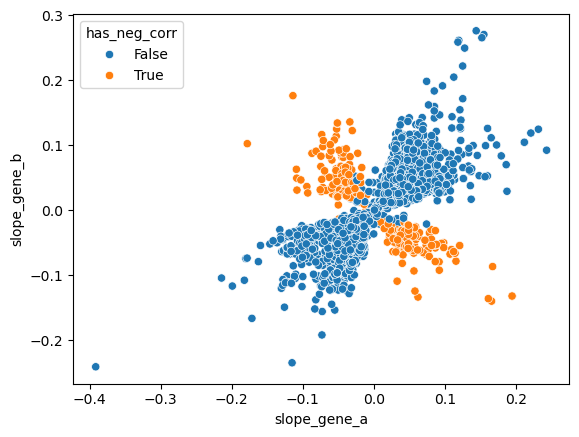

In [22]:
# indep variable is slope for A or B (i.e. mayber larger effect sizes more likely to be shared)
pairegene_cs_grouped['slope_gene_a'] = pairegene_cs_grouped['sig_slope'].str[0]
pairegene_cs_grouped['slope_gene_b'] = pairegene_cs_grouped['sig_slope'].str[1]
sns.scatterplot(pairegene_cs_grouped, x='slope_gene_a', y='slope_gene_b', hue='has_neg_corr')

/local/scratch/klawren/slrmtmp.46699722/ipykernel_28104/3763611146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_clusters['slope_gene_a'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[0]
/local/scratch/klawren/slrmtmp.46699722/ipykernel_28104/3763611146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_clusters['slope_gene_b'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[1]


<AxesSubplot: xlabel='slope_gene_a', ylabel='slope_gene_b'>

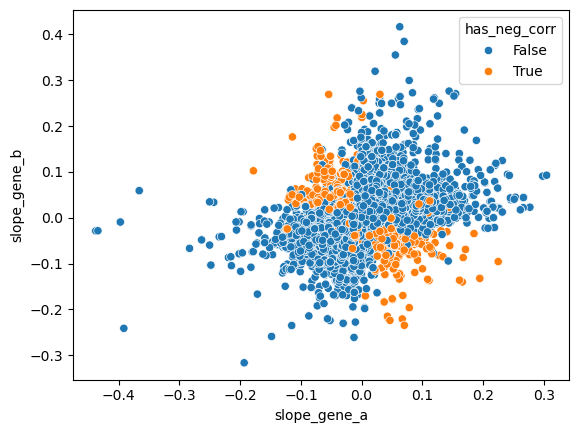

In [41]:
# expand this to all 2 gene clusters, not just ones with multigene qtls
pair_clusters = annot_cs_grouped_pc_susie[annot_cs_grouped_pc_susie['N_genes']==2]
pair_clusters['slope_gene_a'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[0]
pair_clusters['slope_gene_b'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[1]
sns.scatterplot(pair_clusters, x='slope_gene_a', y='slope_gene_b', hue='has_neg_corr')

/local/scratch/klawren/slrmtmp.46699722/ipykernel_28104/1366533527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_clusters['frac_slope'] = np.where(abs(pair_clusters['slope_gene_a']) > abs(pair_clusters['slope_gene_b']), pair_clusters['slope_gene_b']/pair_clusters['slope_gene_a'], pair_clusters['slope_gene_a']/pair_clusters['slope_gene_b'])


<AxesSubplot: xlabel='frac_slope', ylabel='Count'>

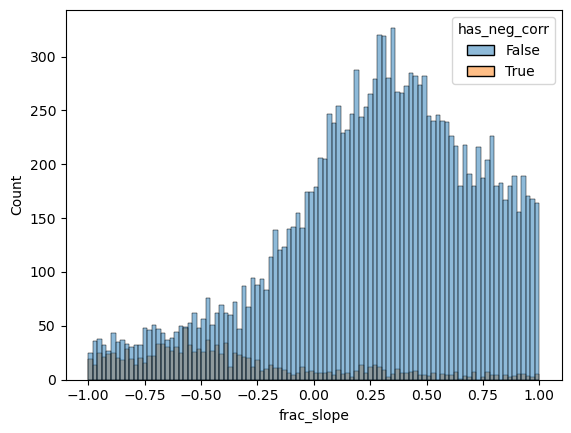

In [42]:
pair_clusters['frac_slope'] = np.where(abs(pair_clusters['slope_gene_a']) > abs(pair_clusters['slope_gene_b']), pair_clusters['slope_gene_b']/pair_clusters['slope_gene_a'], pair_clusters['slope_gene_a']/pair_clusters['slope_gene_b'])
sns.histplot(pair_clusters, x='frac_slope', hue='has_neg_corr', bins=100)

In [52]:
# anything biologically interesting about the neg corr opposite effect ones?
pairegene_cs_grouped['neg_frac_slope'] = pairegene_cs_grouped['frac_slope'] < 0

I want to look at the fraction of average var vs the qtl-tss distance. I hypothesize the closer a qtl is to a gene, the larger the frac var will be. 

Should I include all vars in this? not just the signifigant ones??

### distance

<AxesSubplot: xlabel='sig_tss_var_distance_abs', ylabel='abs_sig_slope'>

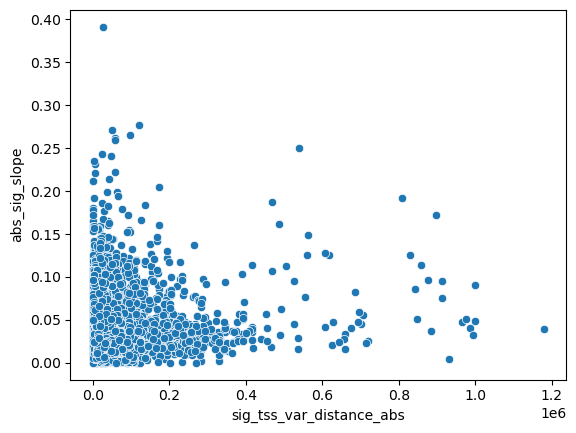

In [72]:
sns.scatterplot(pairegene_cs_grouped.explode(['sig_tss_var_distance_abs', 'abs_sig_slope']), x='sig_tss_var_distance_abs', y='abs_sig_slope')

In [66]:
pairegene_cs_grouped['dist_egene_a'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[0]
pairegene_cs_grouped['dist_egene_b'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[1]
pairegene_cs_grouped['dist_frac'] = np.where(abs(pairegene_cs_grouped['slope_gene_a']) > abs(pairegene_cs_grouped['slope_gene_b']), 
                                             pairegene_cs_grouped['dist_egene_b']/pairegene_cs_grouped['dist_egene_a'], 
                                             pairegene_cs_grouped['dist_egene_a']/pairegene_cs_grouped['dist_egene_b'])

pairegene_cs_grouped['log_dist_frac'] = np.where(abs(pairegene_cs_grouped['slope_gene_a']) > abs(pairegene_cs_grouped['slope_gene_b']), 
                                                 np.log10(pairegene_cs_grouped['dist_egene_b']+1) - np.log10(pairegene_cs_grouped['dist_egene_a']+1), 
                                                 np.log10(pairegene_cs_grouped['dist_egene_a']+1) - np.log10(pairegene_cs_grouped['dist_egene_b']+1))

<AxesSubplot: xlabel='log_dist_frac', ylabel='Percent'>

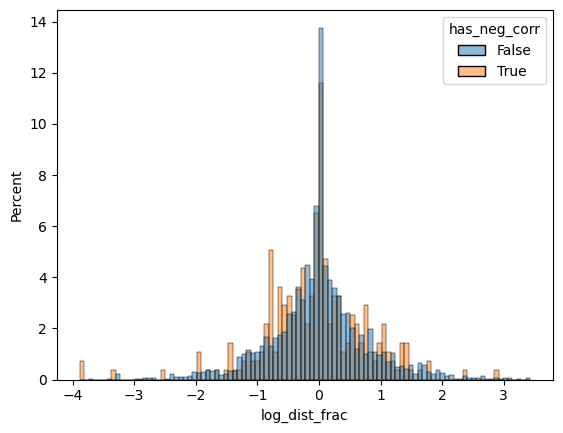

In [67]:
sns.histplot(pairegene_cs_grouped, x='log_dist_frac', hue='has_neg_corr', bins=100, common_norm=False, stat='percent')

In [74]:
pairegene_cs_grouped['dist_frac'].min()

8.667013347200555e-05

(-5.0, 5.0)

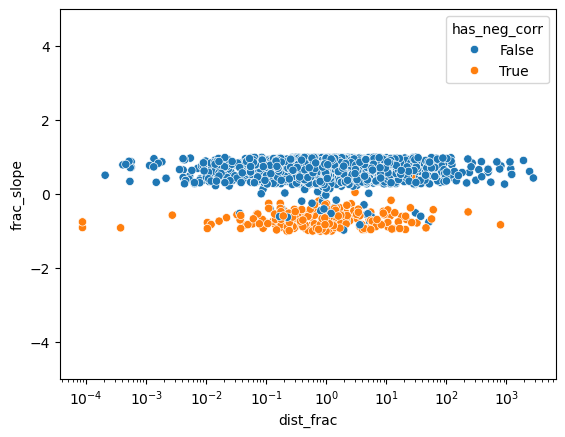

In [73]:
sns.scatterplot(pairegene_cs_grouped, x='dist_frac', y='frac_slope', hue='has_neg_corr')
plt.xscale('log')
plt.ylim(-5, 5)

In [ ]:
sns.scatterplot(pairegene_cs_grouped, x='log_dist_frac', y='frac_slope', hue='has_neg_corr')


#### average expression

In [57]:
average_expression = pd.read_csv(f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv', sep='\t', index_col=0)

<AxesSubplot: xlabel='log_expression_gene_b', ylabel='slope_gene_b'>

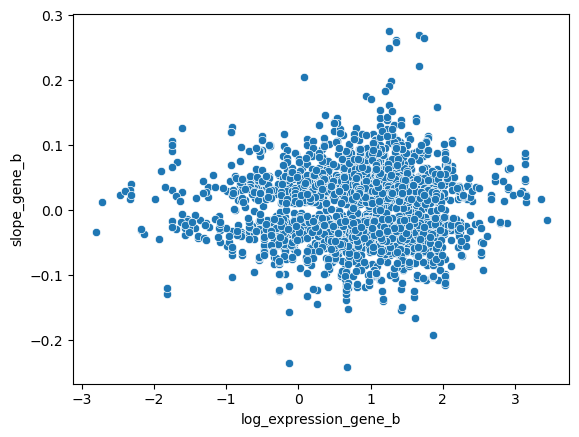

In [63]:
pairegene_cs_grouped['sig_egene_a'] = pairegene_cs_grouped['sig_egenes'].str[0]
pairegene_cs_grouped['sig_egene_b'] = pairegene_cs_grouped['sig_egenes'].str[1]

pairegene_cs_grouped['log_expression_gene_a'] = np.log10(average_expression.loc[my_tissue_id].loc[pairegene_cs_grouped['sig_egene_a']].values)
pairegene_cs_grouped['log_expression_gene_b'] = np.log10(average_expression.loc[my_tissue_id].loc[pairegene_cs_grouped['sig_egene_b']].values)

sns.scatterplot(pairegene_cs_grouped, x='log_expression_gene_b', y='slope_gene_b')

<AxesSubplot: xlabel='log_expression_gene_a', ylabel='log_expression_gene_b'>

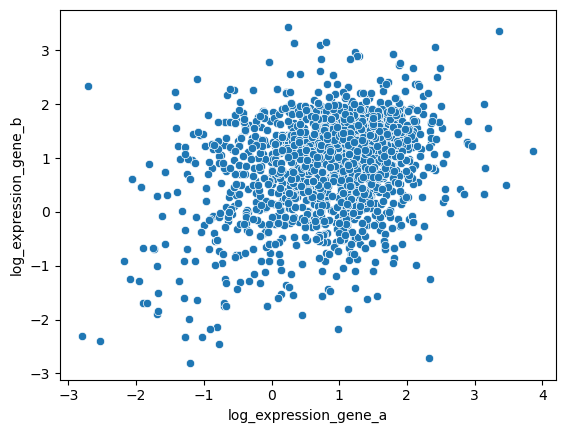

In [62]:
sns.scatterplot(pairegene_cs_grouped, x='log_expression_gene_a', y='log_expression_gene_b')

(-5.0, 5.0)

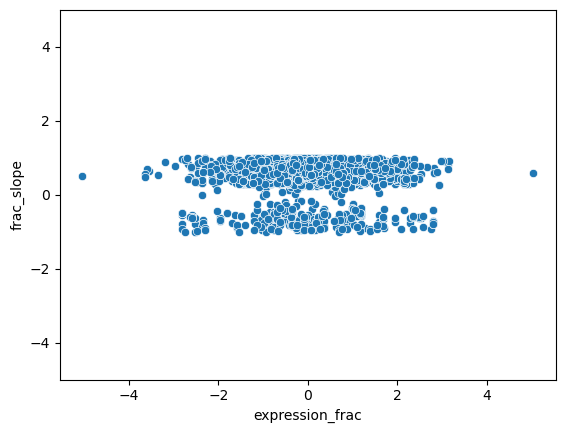

In [65]:
pairegene_cs_grouped['expression_frac'] = np.where(abs(pairegene_cs_grouped['slope_gene_a']) > abs(pairegene_cs_grouped['slope_gene_b']), 
                                                 pairegene_cs_grouped['log_expression_gene_b'] - pairegene_cs_grouped['log_expression_gene_a'], 
                                                 pairegene_cs_grouped['log_expression_gene_a'] - pairegene_cs_grouped['log_expression_gene_b'])
sns.scatterplot(pairegene_cs_grouped, x='expression_frac', y='frac_slope')
plt.ylim(-5, 5)

in ctcfs??

## abc connection

In [248]:
gene_enhancer_df = load_abc(my_tissue_id)
gene_enhancer_df

,gene_name,TargetGene,enhancer,class,ABC.Score
transcript_id,,,,,
ENSG00000187634.11,SAMD11,SAMD11,intergenic|chr1:839603-841066,intergenic,0.022024
ENSG00000187634.11,SAMD11,SAMD11,intergenic|chr1:858775-859990,intergenic,0.038341
ENSG00000187634.11,SAMD11,SAMD11,promoter|chr1:859998-860794,promoter,0.110157
ENSG00000187634.11,SAMD11,SAMD11,genic|chr1:873422-874506,genic,0.019998
ENSG00000187634.11,SAMD11,SAMD11,genic|chr1:875493-876581,genic,0.027442
...,...,...,...,...,...
ENSG00000168939.11_PAR_Y,SPRY3,SPRY3,genic|chrX:153596915-153598726,genic,0.022562
ENSG00000168939.11_PAR_Y,SPRY3,SPRY3,promoter|chrX:154995885-154998520,promoter,0.315121
ENSG00000124333.15_PAR_Y,VAMP7,VAMP7,genic|chrX:153596915-153598726,genic,0.019883
